In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree

In [91]:
from src.neuron_population import NeuronPopulation
from src.connectome import Connectome
from src.overhead import Simulation
from src.neuron_templates import neuron_type_IZ
from src.network_grower import *
from src.network_generators import *
from src.neuron_type_distributor import *
from src.network_weight_distributor import *
from src.external_inputs import *

## Constants

In [92]:
weight_scale = 1.0

g = 10.0

J_I = weight_scale * g
J_E = weight_scale
delay_mean = 200
delay_std = 0.0
v_ext = 0.4

excitatory_type = "ss4"
inhibitory_type = "ss4_I"

## Generate network

In [93]:
G = nx.DiGraph()

# Add 3 nodes
for i in range(3):
    G.add_node(i)

# Assign 2 nodes as excitatory and 1 as inhibitory
excitatory_nodes = random.sample(range(3), 2)
for i in range(3):
    if i in excitatory_nodes:
        G.nodes[i]['inhibitory'] = False
        G.nodes[i]['ntype'] = excitatory_type
        G.nodes[i]['layer'] = 0
    else:
        G.nodes[i]['inhibitory'] = True
        G.nodes[i]['ntype'] = inhibitory_type
        G.nodes[i]['layer'] = 0

# Make network fully connected (except self-connections)
for i in range(3):
    for j in range(3):
        if i != j:
            if G.nodes[i]['inhibitory']:
                weight = J_I
            else:
                weight = J_E
            delay = max(0.1, np.random.normal(delay_mean, delay_std))
            G.add_edge(i, j, weight=weight, distance=delay)

In [94]:
# Print edges with weights and delays
for u, v, data in G.edges(data=True):
    print(f"Edge from {u} to {v}: weight = {data['weight']}, delay = {data['distance']}")

Edge from 0 to 1: weight = 1.0, delay = 200.0
Edge from 0 to 2: weight = 1.0, delay = 200.0
Edge from 1 to 0: weight = 1.0, delay = 200.0
Edge from 1 to 2: weight = 1.0, delay = 200.0
Edge from 2 to 0: weight = 10.0, delay = 200.0
Edge from 2 to 1: weight = 10.0, delay = 200.0


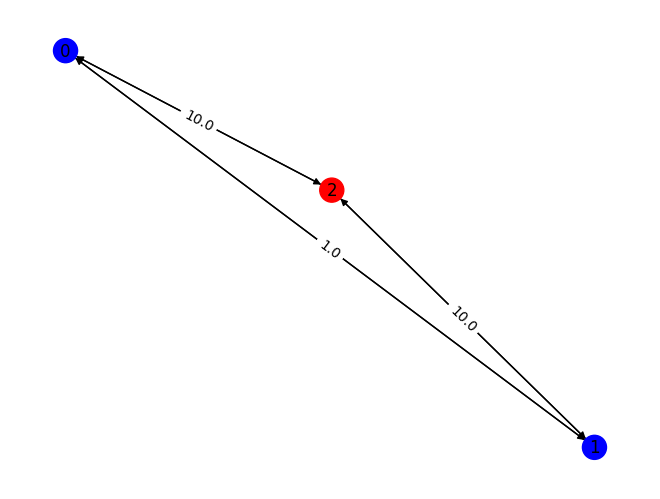

In [95]:
# plot the graph
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, node_color=['red' if G.nodes[i]['inhibitory'] else 'blue' for i in G.nodes()])
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

## Simulation setup

In [96]:
dt = 0.1

In [97]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = [excitatory_type, inhibitory_type]
n_neuron_types = len(neuron_types)
inhibitory = [False, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [98]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

## Simulation

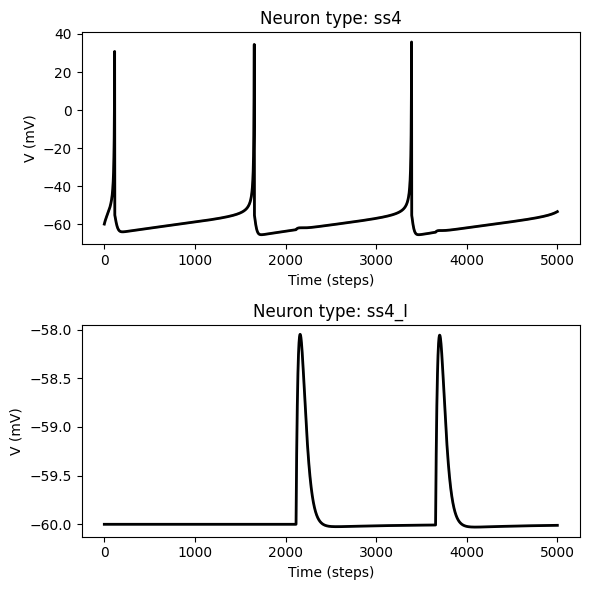

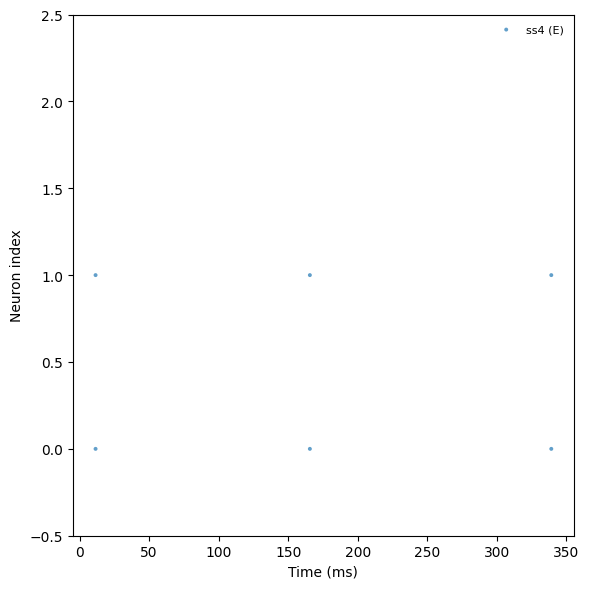

In [99]:

# Randomize initial voltages
# Vs = np.random.uniform(-100, -70, size=n_neurons)
# us = np.random.uniform(0, 400, size=n_neurons)
# spikes = np.zeros(n_neurons, dtype=bool)
# Ts = np.zeros_like(spikes)

# state0 = (Vs,
#           us,
#           spikes.copy(),
#           Ts.copy())

# sim = Simulation(connectome, dt, stepper_type="euler_det", state0=state0)

sim = Simulation(connectome, dt, stepper_type="euler_det")


# 
# rate = np.ones(n_neurons)
# rate[0] = 0.0
# poisson = PoissonInput(n_neurons, rate=rate * v_ext, amplitude=J_E)

I_ext = np.zeros(n_neurons)
I_ext[0] = 200.0
I_ext[1] = 200.0
# I_ext[2] = 200.0

for i in range(5000):
    # sensory_spikes = poisson(dt)
    # sim.step(spike_ext=sensory_spikes)
    sim.step(I_ext=I_ext)

sim.plot_voltage_per_type(figsize=(6, 6))

sim.plot_spike_raster(figsize=(6, 6))

In [100]:
sim.stats.compute_metrics(dt, bin_ms_participation=300)

{'rate_mean_Hz': 3.9992001599680065,
 'rate_median_Hz': 5.9988002399520095,
 'rate_p95_Hz': 5.9988002399520095,
 'ISI_CV_median': 0.08415369077296696,
 'ISI_CV_mean': 0.08415369077296696,
 'ISI_CV_mean_E': 0.08415369077296696,
 'ISI_CV_mean_I': 0.0,
 'ISI_CV_mean_top10pct': 0.08415369077296696,
 'refractory_violations_per_neuron': 0.0,
 'Fano_median_300ms': 0.0,
 'mean_noise_corr_50ms': 0.0,
 'participation_frac_mean_300ms': 0.6666666666666666,
 'participation_frac_median_300ms': 0.6666666666666666,
 'participation_frac_p95_300ms': 0.6666666666666666,
 'participation_frac_total': 0.6666666666666666,
 'pop_spec_entropy': 7.494583127308233,
 'pop_psd_freq_hz': array([0.00000000e+00, 1.99960008e+00, 3.99920016e+00, ...,
        4.99500100e+03, 4.99700060e+03, 4.99900020e+03]),
 'pop_psd': array([2.64644867e-31, 1.43752878e-01, 6.53487401e-01, ...,
        4.30836813e+01, 7.77678359e+00, 2.98143482e+01])}